### **Excerpt from EDA**

The columns that could be used for featurization of our input data are 

1. location_number
2. status_x 
3. verified_x 
4. location_type
5. vendor_category_en
6. serving_distance
7. is_open
8. prepartion_time
9. status_y
10. verifies_y
11. rank
12. language
13. vendor_rating
14. vendor_tag and vendor_tag_name

## **Data pre-processing and one-hot-encoding of multi-class variables**

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! kaggle datasets download mrmorj/restaurant-recommendation-challenge

 99% 529M/534M [00:05<00:00, 134MB/s]
100% 534M/534M [00:05<00:00, 107MB/s]


In [3]:
!unzip /content/restaurant-recommendation-challenge.zip -d Restaurant


Archive:  /content/restaurant-recommendation-challenge.zip
  inflating: Restaurant/SampleSubmission (1).csv  
  inflating: Restaurant/VariableDefinitions.txt  
  inflating: Restaurant/orders.csv   
  inflating: Restaurant/test_customers.csv  
  inflating: Restaurant/test_full.csv  
  inflating: Restaurant/test_locations.csv  
  inflating: Restaurant/train_customers.csv  
  inflating: Restaurant/train_full.csv  
  inflating: Restaurant/train_locations.csv  
  inflating: Restaurant/vendors.csv  


In [1]:
import numpy as np
import pandas as pd
import scipy.sparse
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.sparse import hstack

from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import seaborn as sns
import matplotlib.pyplot as plt 
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_full=pd.read_csv("/content/Restaurant/train_full.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_full.iloc[:,0:72], train_full['target'], test_size=0.33, 
                                                    random_state=42,stratify=train_full['target'])


**Replacing nan values of X-train**

In [ ]:
# replacing all nan values with mode value of the column
for column in X_train.columns:
    X_train[column].fillna(X_train[column].mode()[0], inplace=True)

In [ ]:
X_train.shape

(3887608, 72)

**Replacing nan values of X-test**

In [ ]:
# replacing all nan values with mode value of the column
for column in X_test.columns:
    X_test[column].fillna(X_test[column].mode()[0], inplace=True)

In [ ]:
X_test.shape

(1914792, 72)

In [ ]:
X_train.to_csv('/content/drive/MyDrive/Restaurant_recommendation_system/X_train.csv')
X_test.to_csv('/content/drive/MyDrive/Restaurant_recommendation_system/X_test.csv')

In [ ]:
y_train.to_csv('/content/drive/MyDrive/Restaurant_recommendation_system/y_train.csv')
y_test.to_csv('/content/drive/MyDrive/Restaurant_recommendation_system/y_test.csv')

In [6]:
X_train = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/X_train.csv',index_col=[0])
X_test = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/X_test.csv',index_col=[0])

In [7]:
y_train = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/y_train.csv',index_col=[0])
y_test = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/y_test.csv',index_col=[0])

# **1. One_hot_encoding of categorical variables**

In [ ]:
# function to encode categorical features

def encode_cat_var(data_df):

  categorical_col_list=['gender','location_number','location_type','vendor_category_en','rank']

  categorical_binary_df = pd.DataFrame()

  for i in range(len(categorical_col_list)):

    unique_values=data_df[categorical_col_list[i]].unique()

    for label in unique_values:
      categorical_binary_df[categorical_col_list[i]+'_'+str(label)] = np.where(data_df[categorical_col_list[i]]==label,1,0)

  return categorical_binary_df

In [ ]:
X_train_cat=encode_cat_var(X_train)
X_train_cat.shape

(3887608, 39)

In [ ]:
X_test_cat=encode_cat_var(X_test)
X_test_cat.shape

(1914792, 39)

In [ ]:
# saving the features name in a list for later use

train_feature_list=[]
train_columns_list=list(X_train_cat.columns)

for i in train_columns_list:
  train_feature_list.append(i)

test_feature_list=[]
test_columns_list=list(X_test_cat.columns)

for i in test_columns_list:
  test_feature_list.append(i)

In [ ]:
print(train_feature_list)

['gender_Female', 'gender_Male', 'location_number_0', 'location_number_1', 'location_number_3', 'location_number_2', 'location_number_4', 'location_number_5', 'location_number_7', 'location_number_18', 'location_number_8', 'location_number_6', 'location_number_14', 'location_number_9', 'location_number_19', 'location_number_10', 'location_number_28', 'location_number_12', 'location_number_13', 'location_number_17', 'location_number_16', 'location_number_11', 'location_number_21', 'location_number_15', 'location_number_27', 'location_number_24', 'location_number_20', 'location_number_22', 'location_number_25', 'location_number_26', 'location_number_29', 'location_number_23', 'location_type_Home', 'location_type_Other', 'location_type_Work', 'vendor_category_en_Restaurants', 'vendor_category_en_Sweets & Bakes', 'rank_11', 'rank_1']


In [ ]:
print(test_feature_list)

['gender_Male', 'gender_Female', 'location_number_0', 'location_number_1', 'location_number_3', 'location_number_2', 'location_number_5', 'location_number_4', 'location_number_7', 'location_number_6', 'location_number_13', 'location_number_11', 'location_number_10', 'location_number_9', 'location_number_29', 'location_number_14', 'location_number_8', 'location_number_24', 'location_number_15', 'location_number_12', 'location_number_22', 'location_number_16', 'location_number_25', 'location_number_26', 'location_number_28', 'location_number_20', 'location_number_17', 'location_number_18', 'location_number_27', 'location_number_23', 'location_number_19', 'location_number_21', 'location_type_Home', 'location_type_Work', 'location_type_Other', 'vendor_category_en_Restaurants', 'vendor_category_en_Sweets & Bakes', 'rank_11', 'rank_1']


In [ ]:
X_train_cat.to_csv('/content/drive/MyDrive/Restaurant_recommendation_system/X_train_cat.csv')
X_test_cat.to_csv('/content/drive/MyDrive/Restaurant_recommendation_system/X_test_cat.csv')

In [ ]:
X_train_cat = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/X_train_cat.csv',index_col=[0])
X_test_cat = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/X_test_cat.csv',index_col=[0])

In [ ]:
# saving for further stacking

train_cat_fea_csr=csr_matrix(X_train_cat.values)
scipy.sparse.save_npz('/content/drive/MyDrive/Restaurant_recommendation_system/train_cat_fea_sparse.npz', train_cat_fea_csr)

test_cat_fea_csr=csr_matrix(X_test_cat.values)
scipy.sparse.save_npz('/content/drive/MyDrive/Restaurant_recommendation_system/test_cat_fea_sparse.npz', test_cat_fea_csr)

# **2. Encoding numerical features**

In [69]:
def num_features(data_df):

  numerical_features=['delivery_charge','vendor_rating','serving_distance','prepration_time']

  numerical_features_df = pd.DataFrame()

  for i in numerical_features:

    numerical_features_df[i] = (data_df[i] - data_df[i].min()) / (data_df[i].max() - data_df[i].min())    
  
  return numerical_features_df

In [70]:
X_train_num=num_features(X_train)
X_train_num.shape

(3887608, 4)

In [71]:
X_test_num=num_features(X_test)
X_test_num.shape

(1914792, 4)

# **3. Feature to count the previous orders of a customer from a vendor**

In [9]:
orders=pd.read_csv('/content/Restaurant/orders.csv')
orders.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,16,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83


In [56]:
# counting orders from orders dataset

#selecting customer_id and vendor_id from the orders data
new_orders_df=orders[['customer_id','vendor_id']]

# counting the repeated orders
new_orders_df=new_orders_df.groupby(new_orders_df.columns.tolist(),as_index=False).size()
previous_orders=new_orders_df['size'].tolist()
new_orders_df=new_orders_df.drop('size',axis=1)
new_orders_df['previous_orders']=previous_orders
new_orders_df.head(3)

,customer_id,vendor_id,previous_orders
0,000THBA,148,1
1,002510Y,157,1
2,005ECL6,237,2


**previous orders count for x_train**

In [65]:
train_df=X_train[['customer_id','id']]
train_df.rename(columns={'id':'vendor_id'},inplace=True)

train_previous_orders_df=train_df.join(new_orders_df.set_index(['customer_id','vendor_id']),on=['customer_id','vendor_id'])
train_previous_orders_df=train_previous_orders_df.fillna(0)

train_previous_orders_df['previous_orders'] = (train_previous_orders_df['previous_orders']- train_previous_orders_df['previous_orders'].min()) / (train_previous_orders_df['previous_orders'].max() - train_previous_orders_df['previous_orders'].min())    
train_previous_orders_df=train_previous_orders_df.drop(['customer_id','vendor_id'],axis=1)

train_previous_orders_df.head(3)

,previous_orders
2827710,0.0
4504848,0.0
5102721,0.0


In [74]:
X_train_num['previous_orders']=train_previous_orders_df['previous_orders']

# saving feature names
train_feature_list=[]
numerical_features_list=list(X_train_num.columns)

for i in numerical_features_list:
  train_feature_list.append(i)

print(train_feature_list)

['delivery_charge', 'vendor_rating', 'serving_distance', 'prepration_time', 'previous_orders']


In [76]:
# saving for further stacking

train_num_fea_csr=csr_matrix(X_train_num.values)
scipy.sparse.save_npz('/content/drive/MyDrive/Restaurant_recommendation_system/new_train_num_fea_sparse_1.npz', train_num_fea_csr)

**previous orders count for x_test**

In [68]:
test_df=X_test[['customer_id','id']]
test_df.rename(columns={'id':'vendor_id'},inplace=True)

test_previous_orders_df=test_df.join(new_orders_df.set_index(['customer_id','vendor_id']),on=['customer_id','vendor_id'])
test_previous_orders_df=test_previous_orders_df.fillna(0)

test_previous_orders_df['previous_orders'] = (test_previous_orders_df['previous_orders']- test_previous_orders_df['previous_orders'].min()) / (test_previous_orders_df['previous_orders'].max() - test_previous_orders_df['previous_orders'].min())    
test_previous_orders_df=test_previous_orders_df.drop(['customer_id','vendor_id'],axis=1)
test_previous_orders_df.head(3)

,previous_orders
5492335,0.0
3009121,0.0
1571108,0.0


In [75]:
X_test_num['previous_orders']=test_previous_orders_df['previous_orders']

# saving feature names
test_feature_list=[]
numerical_features_list=list(X_test_num.columns)

for i in numerical_features_list:
  test_feature_list.append(i)

print(test_feature_list)

['delivery_charge', 'vendor_rating', 'serving_distance', 'prepration_time', 'previous_orders']


In [77]:
# saving for further stacking

test_num_fea_csr=csr_matrix(X_test_num.values)
scipy.sparse.save_npz('/content/drive/MyDrive/Restaurant_recommendation_system/new_test_num_fea_sparse_1.npz', test_num_fea_csr)

# **4. Bag Of Words representation of vendor_tag_name**

In [ ]:
def bow_rep(data_df):

  bow_df=pd.DataFrame()
  bow_df['vendor_tag_name']=data_df['vendor_tag_name'].tolist()

  #replacing nan values with mode of the column
  mode_value=bow_df.vendor_tag_name.mode()
  bow_df['vendor_tag_name'] = bow_df['vendor_tag_name'].replace(np.nan, mode_value[0])

  # data cleaning of bow_df

  bow_df['vendor_tag_name'] = [str(x).replace(',',' ') for x in bow_df['vendor_tag_name']]
  bow_df['vendor_tag_name'] = [x.lower() for x in bow_df['vendor_tag_name']]

  # vectorizing the text data

  vectorizer = CountVectorizer()
  vectorizer.fit(bow_df['vendor_tag_name'].values) 

  count_vectorized_bow = vectorizer.transform(bow_df['vendor_tag_name'].values)
  count_vectorized_bow_df = pd.DataFrame(count_vectorized_bow.toarray())

  new_list=list(vectorizer.get_feature_names())
  new_list=['BOW'+'_'+str(i) for i in new_list]
  count_vectorized_bow_df.columns = new_list
  count_vectorized_bow_df.head(5)

  return count_vectorized_bow_df

**bow on train data**

In [ ]:
train_bow_df = bow_rep(X_train)

In [ ]:
# saving feature names for further use

bow_features_list=list(train_bow_df.columns)

for i in bow_features_list:
  train_feature_list.append(i)

In [ ]:
print(train_feature_list)

['gender_Female', 'gender_Male', 'location_number_0', 'location_number_1', 'location_number_3', 'location_number_2', 'location_number_4', 'location_number_5', 'location_number_7', 'location_number_18', 'location_number_8', 'location_number_6', 'location_number_14', 'location_number_9', 'location_number_19', 'location_number_10', 'location_number_28', 'location_number_12', 'location_number_13', 'location_number_17', 'location_number_16', 'location_number_11', 'location_number_21', 'location_number_15', 'location_number_27', 'location_number_24', 'location_number_20', 'location_number_22', 'location_number_25', 'location_number_26', 'location_number_29', 'location_number_23', 'location_type_Home', 'location_type_Other', 'location_type_Work', 'vendor_category_en_Restaurants', 'vendor_category_en_Sweets & Bakes', 'rank_11', 'rank_1', 'delivery_charge', 'vendor_rating', 'serving_distance', 'prepration_time', 'previous_orders', 'BOW_american', 'BOW_arabic', 'BOW_asian', 'BOW_bagels', 'BOW_bi

In [ ]:
# saving for further stacking

train_bow_csr=csr_matrix(train_bow_df.values)
scipy.sparse.save_npz('/content/drive/MyDrive/Restaurant_recommendation_system/train_bow_sparse.npz', train_bow_csr)

**bow on test data**

In [ ]:
test_bow_df = bow_rep(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# saving feature names for further use

bow_features_list=list(test_bow_df.columns)

for i in bow_features_list:
  test_feature_list.append(i)

In [ ]:
print(test_feature_list)

['gender_Male', 'gender_Female', 'location_number_0', 'location_number_1', 'location_number_3', 'location_number_2', 'location_number_5', 'location_number_4', 'location_number_7', 'location_number_6', 'location_number_13', 'location_number_11', 'location_number_10', 'location_number_9', 'location_number_29', 'location_number_14', 'location_number_8', 'location_number_24', 'location_number_15', 'location_number_12', 'location_number_22', 'location_number_16', 'location_number_25', 'location_number_26', 'location_number_28', 'location_number_20', 'location_number_17', 'location_number_18', 'location_number_27', 'location_number_23', 'location_number_19', 'location_number_21', 'location_type_Home', 'location_type_Work', 'location_type_Other', 'vendor_category_en_Restaurants', 'vendor_category_en_Sweets & Bakes', 'rank_11', 'rank_1', 'delivery_charge', 'vendor_rating', 'serving_distance', 'prepration_time', 'previous_orders', 'BOW_american', 'BOW_arabic', 'BOW_asian', 'BOW_bagels', 'BOW_bi

In [ ]:
# saving for further stacking

test_bow_csr=csr_matrix(test_bow_df.values)
scipy.sparse.save_npz('/content/drive/MyDrive/Restaurant_recommendation_system/test_bow_sparse.npz', test_bow_csr)

# **5. Computing Similarity features of customers and vendors**

**5.1. Customer-Customer similarity**

**5.2. Vendor-vendor similarity**

In [8]:
orders=pd.read_csv('/content/Restaurant/orders.csv')
orders.head(3)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,16,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83


In [65]:
print(orders.columns)

Index(['akeed_order_id', 'customer_id', 'item_count', 'grand_total',
       'payment_mode', 'promo_code', 'vendor_discount_amount',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'vendor_rating', 'driver_rating', 'deliverydistance', 'preparationtime',
       'delivery_time', 'order_accepted_time', 'driver_accepted_time',
       'ready_for_pickup_time', 'picked_up_time', 'delivered_time',
       'delivery_date', 'vendor_id', 'created_at', 'LOCATION_NUMBER',
       'LOCATION_TYPE', 'CID X LOC_NUM X VENDOR'],
      dtype='object')


In [9]:
# counting orders from train dataset

#selecting customer_id and vendor_id from the orders data
new_orders_df=orders[['customer_id','vendor_id']]

# counting the repeated orders
new_orders_df=new_orders_df.groupby(new_orders_df.columns.tolist(),as_index=False).size()
count_orders=new_orders_df['size'].tolist()
new_orders_df['count_orders']=count_orders

# mapping customer_id to an integer value
customer_id_list=new_orders_df['customer_id']
x = list(set(customer_id_list))
customer_id_list_dic = dict(zip(x, list(range(1,len(x)+1))))
new_cust_id=[customer_id_list_dic[v] for v in customer_id_list]
new_orders_df['new_cust_id']=new_cust_id
new_orders_df.head(5)

new_orders_df_matrix = sparse.csr_matrix((new_orders_df.count_orders.values, 
                                         (new_orders_df.new_cust_id.values,
                                          new_orders_df.vendor_id.values)))

print('Done. It\'s shape is : (new_cust_id, vendor_id) : ',new_orders_df_matrix.shape)
sparse.save_npz("new_orders_df_matrix.npz", new_orders_df_matrix)

Done. It's shape is : (new_cust_id, vendor_id) :  (27446, 908)


In [77]:
def get_sparse_matrix(sparse_matrix, path, verbose = True):

    # get (row, col) and (orders) tuple from sparse_matrix...
    row_ind, col_ind, orders = sparse.find(sparse_matrix)
    customers = np.unique(row_ind)
    vendors = np.unique(col_ind)

    print("Original Matrix : (customers, vendors) -- ({} {})".format(len(customers), len(vendors)))
    print("Original Matrix : orders -- {}\n".format(len(orders)))

    mask = np.logical_and( np.isin(row_ind, customers),
                      np.isin(col_ind, vendors) )
    
    get_sparse_matrix = sparse.csr_matrix((orders[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(customers)+1, max(vendors)+1))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, get_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return get_sparse_matrix

In [78]:
orders_sparse_matrix = get_sparse_matrix(new_orders_df_matrix,path = "orders_sparse_matrix.npz")

Original Matrix : (customers, vendors) -- (27445 100)
Original Matrix : orders -- 71484

Saving it into disk for furthur usage..
Done..



In [79]:
# Return the indices and values of the nonzero elements of a matrix

customers_ind, vendors_ind, count_orders_val = sparse.find(new_orders_df_matrix)

In [82]:
# calculating customer-customer similarity and vendor-vendor similarity for all pairs of customer-vendor 

start = datetime.now()
if os.path.isfile('reg_train2.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(count_orders_val)))
    with open('reg_train2.csv', mode='w') as reg_data_file:
        count = 0
        for (customer, vendor, count_order)  in zip(customers_ind, vendors_ind, count_orders_val ):
            st = datetime.now()

            #--------------------- Count_orders by similar customers of "customer" ---------------------

            # compute the similar customers of "customer"       
            customer_sim = cosine_similarity(orders_sparse_matrix[customer], orders_sparse_matrix).ravel()
            top_sim_customers = customer_sim.argsort()[::-1][1:] # we are ignoring 'The Customer' from its similar customers.

            # number of orders of most similar customers for this vendor
            top_ratings = orders_sparse_matrix[top_sim_customers, vendor].toarray().ravel()
            top_sim_customers_ratings = list(top_ratings[:5])    


            #--------------------- Number of orders by "customer"  from similar vendors of "vendor" ---------------------

            # compute the similar vendors of the "vendor"        
            vendor_sim = cosine_similarity(orders_sparse_matrix[:,vendor].T, orders_sparse_matrix.T).ravel()
            top_sim_vendors = vendor_sim.argsort()[::-1][1:] # we are ignoring 'The Vendor' from its similar vendors.

            # number of orders from most similar vendor by this customer
            top_ratings = orders_sparse_matrix[customer, top_sim_vendors].toarray().ravel()
            top_sim_vendors_ratings = list(top_ratings[:5])

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(customer)
            row.append(vendor)

            row.extend(top_sim_customers_ratings)
            row.extend(top_sim_vendors_ratings)

            # number of orders for customer-vendor pair
            row.append(count_order)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 71484 tuples for the dataset..

Done for 10000 rows----- 0:01:52.287999
Done for 20000 rows----- 0:03:47.621879
Done for 30000 rows----- 0:05:46.022664
Done for 40000 rows----- 0:07:40.761509
Done for 50000 rows----- 0:09:34.447423
Done for 60000 rows----- 0:11:28.169019
Done for 70000 rows----- 0:13:18.026184
0:13:33.318912


In [17]:
reg_train1 = pd.read_csv('reg_train1.csv', names = ['en_customer_id', 'vendor_id', 'sim_cus_1', 'sim_cus_2', 'sim_cus_3', 'sim_cus_4', 'sim_cus_5','sim_ven_1', 'sim_ven_2', 'sim_ven_3', 'sim_ven_4', 'sim_ven_5', 'count_order'], header=None)
reg_train1.head()

,en_customer_id,vendor_id,sim_cus_1,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,count_order
0,16,4,1,1,1,1,1,0,0,0,0,0,1
1,73,4,6,1,1,1,1,0,0,0,0,0,4
2,91,4,1,0,0,0,0,0,9,0,0,0,1
3,113,4,1,1,0,0,0,0,0,0,0,0,1
4,132,4,2,1,1,1,0,0,0,0,0,2,2


In [18]:
# inserting real customer_ids to the dataframe 

key_list = list(customer_id_list_dic.keys())
val_list = list(customer_id_list_dic.values())
train_customers_id=[]
for i in range(len(reg_train1)):
  train_customers_id.append(key_list[val_list.index(reg_train1['en_customer_id'][i])])

reg_train1['customer_id']=train_customers_id
reg_train1.head(3)

,en_customer_id,vendor_id,sim_cus_1,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,count_order,customer_id
0,16,4,1,1,1,1,1,0,0,0,0,0,1,MEP0XA2
1,73,4,6,1,1,1,1,0,0,0,0,0,4,AK76U3U
2,91,4,1,0,0,0,0,0,9,0,0,0,1,12R5E7S


In [22]:
reg_train1.to_csv('unique_cust_ven.csv')
# reg_train1=pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/unique_cust_ven.csv')

reg_train1.insert(loc=0, column='customer_id', value=train_customers_id)
reg_train1=reg_train1.drop(['en_customer_id'],axis=1)
reg_train1.head(3)

,customer_id,vendor_id,sim_cus_1,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,count_order
0,MEP0XA2,4,1,1,1,1,1,0,0,0,0,0,1
1,AK76U3U,4,6,1,1,1,1,0,0,0,0,0,4
2,12R5E7S,4,1,0,0,0,0,0,9,0,0,0,1


similarity features for train data

In [23]:
#create a dataframe with only 2 columns of X_train

train_df=X_train[['customer_id','id']]
train_df.rename(columns={'id':'vendor_id'},inplace=True)

train_result=train_df.join(reg_train1.set_index(['customer_id','vendor_id']),on=['customer_id','vendor_id'])
train_result=train_result.fillna(0)
train_result.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,customer_id,vendor_id,sim_cus_1,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,count_order
2827710,CYNHRLE,67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4504848,VX882YK,199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5102721,R7SH26P,90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
tr_cus_ven_count = train_result[['customer_id','vendor_id','count_order']]
train_result=train_result.drop(['customer_id','vendor_id','count_order'],axis=1)
tr_cus_ven_count.to_csv('/content/drive/MyDrive/Restaurant_2/tr_cus_ven_count.csv')

tr_sim_features_list=list(train_result.columns)

for i in tr_sim_features_list:

  train_result[i] = (train_result[i] - train_result[i].min()) / (train_result[i].max() - train_result[i].min())    
 
train_result.head(5)

,sim_cus_1,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5
2827710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4504848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5102721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1626247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5454948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
print(tr_sim_features_list)

['sim_cus_1', 'sim_cus_2', 'sim_cus_3', 'sim_cus_4', 'sim_cus_5', 'sim_ven_1', 'sim_ven_2', 'sim_ven_3', 'sim_ven_4', 'sim_ven_5']


In [46]:
train_result_csr=csr_matrix(train_result.values)
scipy.sparse.save_npz('/content/drive/MyDrive/Restaurant_2/train_result_sparse.npz', train_result_csr)

similarity features for test data

In [48]:
#create a dataframe with only 2 columns of X_test

test_df=X_test[['customer_id','id']]
test_df.rename(columns={'id':'vendor_id'},inplace=True)

test_result=test_df.join(reg_train1.set_index(['customer_id','vendor_id']),on=['customer_id','vendor_id'])
test_result=test_result.fillna(0)
test_result.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,customer_id,vendor_id,sim_cus_1,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,count_order
5492335,ADSJ32G,159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3009121,QXRNSE0,90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1571108,EZ5Y3LL,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
te_cus_ven_count = test_result[['customer_id','vendor_id','count_order']]
test_result=test_result.drop(['customer_id','vendor_id','count_order'],axis=1)
te_cus_ven_count.to_csv('/content/drive/MyDrive/Restaurant_2/te_cus_ven_count.csv')

te_sim_features_list=list(test_result.columns)

for i in te_sim_features_list:

  test_result[i] = (test_result[i] - test_result[i].min()) / (test_result[i].max() - test_result[i].min())    
 
test_result.head(5)

,sim_cus_1,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5
5492335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3009121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1571108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
904789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2109164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
print(te_sim_features_list)

['sim_cus_1', 'sim_cus_2', 'sim_cus_3', 'sim_cus_4', 'sim_cus_5', 'sim_ven_1', 'sim_ven_2', 'sim_ven_3', 'sim_ven_4', 'sim_ven_5']


In [52]:
test_result_csr=csr_matrix(test_result.values)
scipy.sparse.save_npz('/content/drive/MyDrive/Restaurant_2/test_result_sparse.npz', test_result_csr)

# **6. Concatenating categorical, numerical, bag_of_words and similarity features**

categorical

In [2]:
# loading train categorical features

train_cat_features_matrix = scipy.sparse.load_npz('/content/drive/MyDrive/Restaurant_recommendation_system/train_cat_fea_sparse.npz')
train_cat_features_matrix.shape

(3887608, 39)

In [3]:
# loading test categorical features

test_cat_features_matrix = scipy.sparse.load_npz('/content/drive/MyDrive/Restaurant_recommendation_system/test_cat_fea_sparse.npz')
test_cat_features_matrix.shape

(1914792, 39)

numerical

In [4]:
# loading  train numerical features

train_num_features_matrix = scipy.sparse.load_npz('/content/drive/MyDrive/Restaurant_recommendation_system/new_train_num_fea_sparse_1.npz')
train_num_features_matrix.shape

(3887608, 5)

In [5]:
# loading test numerical features

test_num_features_matrix = scipy.sparse.load_npz('/content/drive/MyDrive/Restaurant_recommendation_system/new_test_num_fea_sparse_1.npz')
test_num_features_matrix.shape

(1914792, 5)

bag_of_words

In [6]:
# loading train bow features

train_bow_features_matrix = scipy.sparse.load_npz('/content/drive/MyDrive/Restaurant_recommendation_system/train_bow_sparse.npz')
train_bow_features_matrix.shape

(3887608, 75)

In [7]:
# loading test bow  features

test_bow_features_matrix = scipy.sparse.load_npz('/content/drive/MyDrive/Restaurant_recommendation_system/test_bow_sparse.npz')
test_bow_features_matrix.shape

(1914792, 75)

similarity

In [8]:
# loading train similarity features

train_sim_features_matrix = scipy.sparse.load_npz('/content/drive/MyDrive/Restaurant_2/train_result_sparse.npz')
train_sim_features_matrix.shape

(3887608, 10)

In [9]:
# loading test similarity features

test_sim_features_matrix = scipy.sparse.load_npz('/content/drive/MyDrive/Restaurant_2/test_result_sparse.npz')
test_sim_features_matrix.shape

(1914792, 10)

In [10]:
# stacking all the train features

train_sparse = hstack((train_cat_features_matrix, train_num_features_matrix, train_bow_features_matrix ,train_sim_features_matrix )).tocsr()
train_sparse.shape

(3887608, 129)

In [11]:
train_dataframe=pd.DataFrame.sparse.from_spmatrix(train_sparse)
train_dataframe.head(5)

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
train_feature_list=['gender_Female', 'gender_Male', 'location_number_0', 'location_number_1', 'location_number_3', 'location_number_2', 'location_number_4', 'location_number_5', 'location_number_7', 'location_number_18', 'location_number_8', 'location_number_6', 'location_number_14', 'location_number_9', 'location_number_19', 'location_number_10', 'location_number_28', 'location_number_12', 'location_number_13', 'location_number_17', 'location_number_16', 'location_number_11', 'location_number_21', 'location_number_15', 'location_number_27', 'location_number_24', 'location_number_20', 'location_number_22', 'location_number_25', 'location_number_26', 'location_number_29', 'location_number_23', 'location_type_Home', 'location_type_Other', 'location_type_Work', 'vendor_category_en_Restaurants', 'vendor_category_en_Sweets & Bakes', 'rank_11', 'rank_1', 'delivery_charge', 'vendor_rating', 'serving_distance', 'prepration_time', 'previous_orders', 'BOW_american', 'BOW_arabic', 'BOW_asian', 'BOW_bagels', 'BOW_biryani', 'BOW_breakfast', 'BOW_burgers', 'BOW_cafe', 'BOW_cakes', 'BOW_chinese', 'BOW_chocolate', 'BOW_churros', 'BOW_coffee', 'BOW_combos', 'BOW_creams', 'BOW_crepes', 'BOW_delivery', 'BOW_desserts', 'BOW_dimsum', 'BOW_dogs', 'BOW_donuts', 'BOW_family', 'BOW_fatayers', 'BOW_food', 'BOW_free', 'BOW_fresh', 'BOW_fries', 'BOW_frozen', 'BOW_grills', 'BOW_healthy', 'BOW_hot', 'BOW_ice', 'BOW_indian', 'BOW_italian', 'BOW_japanese', 'BOW_juices', 'BOW_karak', 'BOW_kebabs', 'BOW_kids', 'BOW_kushari', 'BOW_latte', 'BOW_lebanese', 'BOW_manakeesh', 'BOW_mandazi', 'BOW_meal', 'BOW_mexican', 'BOW_milkshakes', 'BOW_mishkak', 'BOW_mojitos', 'BOW_omani', 'BOW_organic', 'BOW_pancakes', 'BOW_pasta', 'BOW_pastas', 'BOW_pastry', 'BOW_pizza', 'BOW_pizzas', 'BOW_rice', 'BOW_rolls', 'BOW_salads', 'BOW_sandwiches', 'BOW_seafood', 'BOW_shawarma', 'BOW_shuwa', 'BOW_smoothies', 'BOW_soups', 'BOW_spanish', 'BOW_steaks', 'BOW_sushi', 'BOW_sweets', 'BOW_thai', 'BOW_thali', 'BOW_vegetarian', 'BOW_waffles', 'BOW_yoghurt', 'sim_cus_1', 'sim_cus_2', 'sim_cus_3', 'sim_cus_4', 'sim_cus_5', 'sim_ven_1', 'sim_ven_2', 'sim_ven_3', 'sim_ven_4', 'sim_ven_5']


In [13]:
train_dataframe.columns = train_feature_list
train_dataframe.head(5)

,gender_Female,gender_Male,location_number_0,location_number_1,location_number_3,location_number_2,location_number_4,location_number_5,location_number_7,location_number_18,...,sim_cus_1,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3887608 entries, 0 to 3887607
Columns: 129 entries, gender_Female to sim_ven_5
dtypes: Sparse[float64, 0](129)
memory usage: 673.2 MB


In [15]:
train_dataframe.columns

Index(['gender_Female', 'gender_Male', 'location_number_0',
       'location_number_1', 'location_number_3', 'location_number_2',
       'location_number_4', 'location_number_5', 'location_number_7',
       'location_number_18',
       ...
       'sim_cus_1', 'sim_cus_2', 'sim_cus_3', 'sim_cus_4', 'sim_cus_5',
       'sim_ven_1', 'sim_ven_2', 'sim_ven_3', 'sim_ven_4', 'sim_ven_5'],
      dtype='object', length=129)

In [16]:
train_dataframe_csr=csr_matrix(train_dataframe.values)
scipy.sparse.save_npz('/content/drive/MyDrive/Restaurant_recommendation_system/new1_train_dataframe_sparse_1.npz', train_dataframe_csr)

In [17]:
# stacking all the test features

from scipy.sparse import hstack

test_sparse = hstack((test_cat_features_matrix, test_num_features_matrix, test_bow_features_matrix ,test_sim_features_matrix )).tocsr()
test_sparse.shape

(1914792, 129)

In [18]:
test_dataframe=pd.DataFrame.sparse.from_spmatrix(test_sparse)
test_dataframe.head(5)

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
test_feature_list=['gender_Male', 'gender_Female', 'location_number_0', 'location_number_1', 'location_number_3', 'location_number_2', 'location_number_5', 'location_number_4', 'location_number_7', 'location_number_6', 'location_number_13', 'location_number_11', 'location_number_10', 'location_number_9', 'location_number_29', 'location_number_14', 'location_number_8', 'location_number_24', 'location_number_15', 'location_number_12', 'location_number_22', 'location_number_16', 'location_number_25', 'location_number_26', 'location_number_28', 'location_number_20', 'location_number_17', 'location_number_18', 'location_number_27', 'location_number_23', 'location_number_19', 'location_number_21', 'location_type_Home', 'location_type_Work', 'location_type_Other', 'vendor_category_en_Restaurants', 'vendor_category_en_Sweets & Bakes', 'rank_11', 'rank_1', 'delivery_charge', 'vendor_rating', 'serving_distance', 'prepration_time', 'previous_orders', 'BOW_american', 'BOW_arabic', 'BOW_asian', 'BOW_bagels', 'BOW_biryani', 'BOW_breakfast', 'BOW_burgers', 'BOW_cafe', 'BOW_cakes', 'BOW_chinese', 'BOW_chocolate', 'BOW_churros', 'BOW_coffee', 'BOW_combos', 'BOW_creams', 'BOW_crepes', 'BOW_delivery', 'BOW_desserts', 'BOW_dimsum', 'BOW_dogs', 'BOW_donuts', 'BOW_family', 'BOW_fatayers', 'BOW_food', 'BOW_free', 'BOW_fresh', 'BOW_fries', 'BOW_frozen', 'BOW_grills', 'BOW_healthy', 'BOW_hot', 'BOW_ice', 'BOW_indian', 'BOW_italian', 'BOW_japanese', 'BOW_juices', 'BOW_karak', 'BOW_kebabs', 'BOW_kids', 'BOW_kushari', 'BOW_latte', 'BOW_lebanese', 'BOW_manakeesh', 'BOW_mandazi', 'BOW_meal', 'BOW_mexican', 'BOW_milkshakes', 'BOW_mishkak', 'BOW_mojitos', 'BOW_omani', 'BOW_organic', 'BOW_pancakes', 'BOW_pasta', 'BOW_pastas', 'BOW_pastry', 'BOW_pizza', 'BOW_pizzas', 'BOW_rice', 'BOW_rolls', 'BOW_salads', 'BOW_sandwiches', 'BOW_seafood', 'BOW_shawarma', 'BOW_shuwa', 'BOW_smoothies', 'BOW_soups', 'BOW_spanish', 'BOW_steaks', 'BOW_sushi', 'BOW_sweets', 'BOW_thai', 'BOW_thali', 'BOW_vegetarian', 'BOW_waffles', 'BOW_yoghurt', 'sim_cus_1', 'sim_cus_2', 'sim_cus_3', 'sim_cus_4', 'sim_cus_5', 'sim_ven_1', 'sim_ven_2', 'sim_ven_3', 'sim_ven_4', 'sim_ven_5']

test_dataframe.columns = test_feature_list
test_dataframe.head(5)

,gender_Male,gender_Female,location_number_0,location_number_1,location_number_3,location_number_2,location_number_5,location_number_4,location_number_7,location_number_6,...,sim_cus_1,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
test_dataframe_csr=csr_matrix(test_dataframe.values)
scipy.sparse.save_npz('/content/drive/MyDrive/Restaurant_recommendation_system/new1_test_dataframe_sparse_1.npz', test_dataframe_csr)

# **Applying ML models on featured datasets**

In [2]:
# loading featured train df

train_df = scipy.sparse.load_npz('/content/drive/MyDrive/Restaurant_recommendation_system/new1_train_dataframe_sparse_1.npz')
print(train_df.shape)

train_feature_list=['gender_Female', 'gender_Male', 'location_number_0', 'location_number_1', 'location_number_3', 'location_number_2', 'location_number_4', 'location_number_5', 'location_number_7', 'location_number_18', 'location_number_8', 'location_number_6', 'location_number_14', 'location_number_9', 'location_number_19', 'location_number_10', 'location_number_28', 'location_number_12', 'location_number_13', 'location_number_17', 'location_number_16', 'location_number_11', 'location_number_21', 'location_number_15', 'location_number_27', 'location_number_24', 'location_number_20', 'location_number_22', 'location_number_25', 'location_number_26', 'location_number_29', 'location_number_23', 'location_type_Home', 'location_type_Other', 'location_type_Work', 'vendor_category_en_Restaurants', 'vendor_category_en_Sweets & Bakes', 'rank_11', 'rank_1', 'delivery_charge', 'vendor_rating', 'serving_distance', 'prepration_time', 'previous_orders', 'BOW_american', 'BOW_arabic', 'BOW_asian', 'BOW_bagels', 'BOW_biryani', 'BOW_breakfast', 'BOW_burgers', 'BOW_cafe', 'BOW_cakes', 'BOW_chinese', 'BOW_chocolate', 'BOW_churros', 'BOW_coffee', 'BOW_combos', 'BOW_creams', 'BOW_crepes', 'BOW_delivery', 'BOW_desserts', 'BOW_dimsum', 'BOW_dogs', 'BOW_donuts', 'BOW_family', 'BOW_fatayers', 'BOW_food', 'BOW_free', 'BOW_fresh', 'BOW_fries', 'BOW_frozen', 'BOW_grills', 'BOW_healthy', 'BOW_hot', 'BOW_ice', 'BOW_indian', 'BOW_italian', 'BOW_japanese', 'BOW_juices', 'BOW_karak', 'BOW_kebabs', 'BOW_kids', 'BOW_kushari', 'BOW_latte', 'BOW_lebanese', 'BOW_manakeesh', 'BOW_mandazi', 'BOW_meal', 'BOW_mexican', 'BOW_milkshakes', 'BOW_mishkak', 'BOW_mojitos', 'BOW_omani', 'BOW_organic', 'BOW_pancakes', 'BOW_pasta', 'BOW_pastas', 'BOW_pastry', 'BOW_pizza', 'BOW_pizzas', 'BOW_rice', 'BOW_rolls', 'BOW_salads', 'BOW_sandwiches', 'BOW_seafood', 'BOW_shawarma', 'BOW_shuwa', 'BOW_smoothies', 'BOW_soups', 'BOW_spanish', 'BOW_steaks', 'BOW_sushi', 'BOW_sweets', 'BOW_thai', 'BOW_thali', 'BOW_vegetarian', 'BOW_waffles', 'BOW_yoghurt', 'sim_cus_1', 'sim_cus_2', 'sim_cus_3', 'sim_cus_4', 'sim_cus_5', 'sim_ven_1', 'sim_ven_2', 'sim_ven_3', 'sim_ven_4', 'sim_ven_5']

train_df=pd.DataFrame.sparse.from_spmatrix(train_df)
train_df.columns = train_feature_list
train_df.head(5)

(3887608, 129)


,gender_Female,gender_Male,location_number_0,location_number_1,location_number_3,location_number_2,location_number_4,location_number_5,location_number_7,location_number_18,...,sim_cus_1,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# loading featured test df

test_df = scipy.sparse.load_npz('/content/drive/MyDrive/Restaurant_recommendation_system/new1_test_dataframe_sparse_1.npz')
print(test_df.shape)

test_feature_list=['gender_Male', 'gender_Female', 'location_number_0', 'location_number_1', 'location_number_3', 'location_number_2', 'location_number_5', 'location_number_4', 'location_number_7', 'location_number_6', 'location_number_13', 'location_number_11', 'location_number_10', 'location_number_9', 'location_number_29', 'location_number_14', 'location_number_8', 'location_number_24', 'location_number_15', 'location_number_12', 'location_number_22', 'location_number_16', 'location_number_25', 'location_number_26', 'location_number_28', 'location_number_20', 'location_number_17', 'location_number_18', 'location_number_27', 'location_number_23', 'location_number_19', 'location_number_21', 'location_type_Home', 'location_type_Work', 'location_type_Other', 'vendor_category_en_Restaurants', 'vendor_category_en_Sweets & Bakes', 'rank_11', 'rank_1', 'delivery_charge', 'vendor_rating', 'serving_distance', 'prepration_time', 'previous_orders', 'BOW_american', 'BOW_arabic', 'BOW_asian', 'BOW_bagels', 'BOW_biryani', 'BOW_breakfast', 'BOW_burgers', 'BOW_cafe', 'BOW_cakes', 'BOW_chinese', 'BOW_chocolate', 'BOW_churros', 'BOW_coffee', 'BOW_combos', 'BOW_creams', 'BOW_crepes', 'BOW_delivery', 'BOW_desserts', 'BOW_dimsum', 'BOW_dogs', 'BOW_donuts', 'BOW_family', 'BOW_fatayers', 'BOW_food', 'BOW_free', 'BOW_fresh', 'BOW_fries', 'BOW_frozen', 'BOW_grills', 'BOW_healthy', 'BOW_hot', 'BOW_ice', 'BOW_indian', 'BOW_italian', 'BOW_japanese', 'BOW_juices', 'BOW_karak', 'BOW_kebabs', 'BOW_kids', 'BOW_kushari', 'BOW_latte', 'BOW_lebanese', 'BOW_manakeesh', 'BOW_mandazi', 'BOW_meal', 'BOW_mexican', 'BOW_milkshakes', 'BOW_mishkak', 'BOW_mojitos', 'BOW_omani', 'BOW_organic', 'BOW_pancakes', 'BOW_pasta', 'BOW_pastas', 'BOW_pastry', 'BOW_pizza', 'BOW_pizzas', 'BOW_rice', 'BOW_rolls', 'BOW_salads', 'BOW_sandwiches', 'BOW_seafood', 'BOW_shawarma', 'BOW_shuwa', 'BOW_smoothies', 'BOW_soups', 'BOW_spanish', 'BOW_steaks', 'BOW_sushi', 'BOW_sweets', 'BOW_thai', 'BOW_thali', 'BOW_vegetarian', 'BOW_waffles', 'BOW_yoghurt', 'sim_cus_1', 'sim_cus_2', 'sim_cus_3', 'sim_cus_4', 'sim_cus_5', 'sim_ven_1', 'sim_ven_2', 'sim_ven_3', 'sim_ven_4', 'sim_ven_5']

test_df=pd.DataFrame.sparse.from_spmatrix(test_df)
test_df.columns = test_feature_list
test_df.head(5)

(1914792, 129)


,gender_Male,gender_Female,location_number_0,location_number_1,location_number_3,location_number_2,location_number_5,location_number_4,location_number_7,location_number_6,...,sim_cus_1,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Train dataset is imbalanced hence we need to do upsampling of minority class in train dataset**

In [4]:
y_train = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/y_train.csv',index_col=[0])
y_test = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/y_test.csv',index_col=[0])

y_train.reset_index(inplace = True,drop=True)
# df.reset_index(drop=True)
print(y_train.head(3))

y_test.reset_index(inplace = True,drop=True)
# df.reset_index(drop=True)
print(y_test.head(3))

   target
0       0
1       0
2       0
   target
0       0
1       0
2       0


0    3835178
1      52430
Name: target, dtype: int64


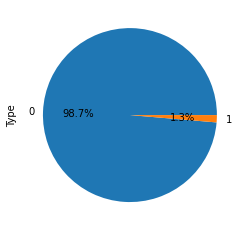

In [5]:
xy_train = pd.concat([train_df, y_train], axis=1)

print(xy_train["target"].value_counts())

xy_train.groupby('target').size().plot(kind='pie',
                                       y = "target",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [6]:
xy_train_0=xy_train[xy_train['target']==0]
print(xy_train_0.shape)
xy_train_1=xy_train[xy_train['target']==1]
print(xy_train_1.shape)

(3835178, 130)
(52430, 130)


In [7]:
from sklearn.utils import resample

xy_train_1_upsample = resample(xy_train_1,
             replace=True,
             n_samples=len(xy_train_0),
             random_state=42)

print(xy_train_1_upsample.shape)

(3835178, 130)


0    3835178
1    3835178
Name: target, dtype: int64


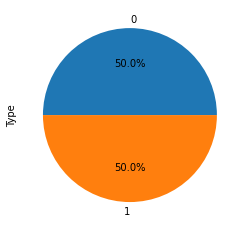

In [8]:
train_upsampled = pd.concat([xy_train_0, xy_train_1_upsample])
print(train_upsampled["target"].value_counts())

train_upsampled.groupby('target').size().plot(kind='pie',
                                       y = "target",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [9]:
y_tr=pd.DataFrame()
y_tr['target']=train_upsampled['target']
print(y_tr.shape)

train_upsampled=train_upsampled.drop(['target'], axis = 1)
print(train_upsampled.shape)

(7670356, 1)
(7670356, 129)


# **Applying logistic regression**

In [ ]:
clf = LogisticRegression(random_state=42).fit(train_upsampled, y_tr)

y_pred=clf.predict(test_df)
acc_score=accuracy_score(y_test, y_pred)
f1_score_=f1_score(y_test, y_pred)


In [11]:
print('the accuracy obtained after applying logistic regression is ',acc_score)
print('the f1 score obtained after applying logistic regression is ',f1_score_)

the accuracy obtained after applying logistic regression is  0.9841867941792111
the f1 score obtained after applying logistic regression is  0.6041495077852296


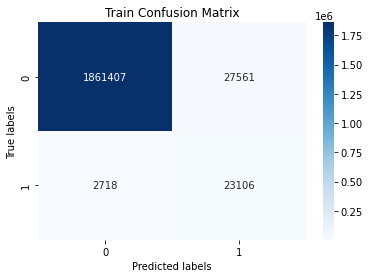

In [12]:
g=confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot();
sns.heatmap(np.array(g), annot=True,fmt="d",cmap='Blues',ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Train Confusion Matrix');

# **Applying decision tree**

In [13]:
max_depth_list=[2,5]
min_samples_split=[5, 10, 100, 500, 1000, 2000, 5000]

for i in max_depth_list:

  for j in min_samples_split:

    clf_dt=DecisionTreeClassifier(max_depth=i,min_samples_split=j)
    clf_dt.fit(train_upsampled, y_tr)

    y_pred_dt=clf_dt.predict(test_df)
    acc_score_dt=accuracy_score(y_test, y_pred_dt)
    f1_score_dt=f1_score(y_test, y_pred_dt)

    print('Decision tree with max_depth {} and min_samples_split {}, accuracy obtained is {}. '.format(i,j,acc_score_dt))
    print('Decision tree with max_depth {} and min_samples_split {}, f1_score obtained is {}. '.format(i,j,f1_score_dt))
    print('\n')


Decision tree with max_depth 2 and min_samples_split 5, accuracy obtained is 0.9821912771726642. 
Decision tree with max_depth 2 and min_samples_split 5, f1_score obtained is 0.6023230862527406. 


Decision tree with max_depth 2 and min_samples_split 10, accuracy obtained is 0.9821912771726642. 
Decision tree with max_depth 2 and min_samples_split 10, f1_score obtained is 0.6023230862527406. 


Decision tree with max_depth 2 and min_samples_split 100, accuracy obtained is 0.9821912771726642. 
Decision tree with max_depth 2 and min_samples_split 100, f1_score obtained is 0.6023230862527406. 


Decision tree with max_depth 2 and min_samples_split 500, accuracy obtained is 0.9821912771726642. 
Decision tree with max_depth 2 and min_samples_split 500, f1_score obtained is 0.6023230862527406. 


Decision tree with max_depth 2 and min_samples_split 1000, accuracy obtained is 0.9821912771726642. 
Decision tree with max_depth 2 and min_samples_split 1000, f1_score obtained is 0.602323086252740

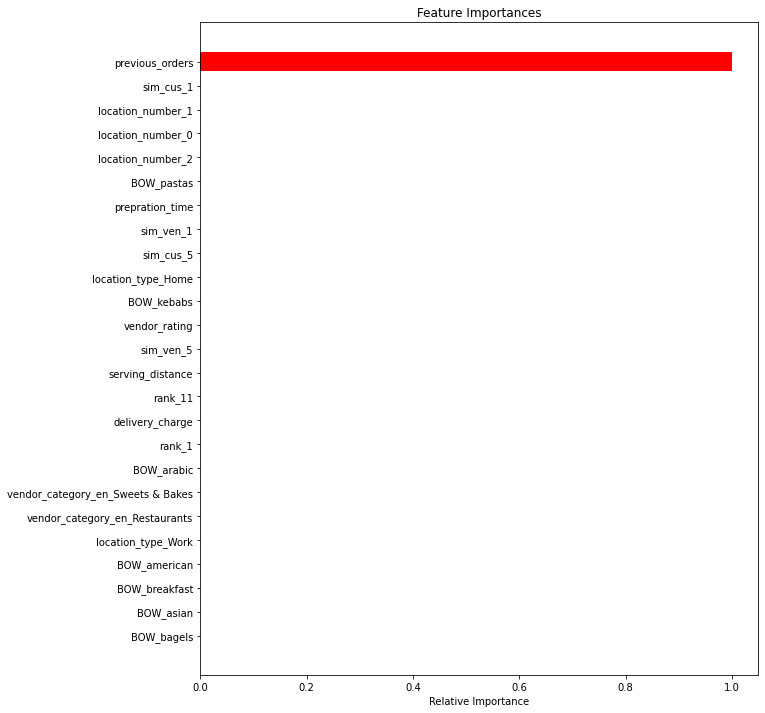

In [14]:
features = train_upsampled.columns
importances = clf_dt.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# **Applying random_forest**

In [15]:
clf_rf = RandomForestClassifier(n_estimators=30, max_depth=2, random_state=0).fit(train_upsampled, y_tr)

y_pred_rf=clf_rf.predict(test_df)
acc_score_rf=accuracy_score(y_test, y_pred_rf)
f1_score_rf=f1_score(y_test, y_pred_rf)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [16]:
print('the accuracy obtained after applying random forest is ',acc_score_rf)
print('the f1_score obtained after applying random forest is ',f1_score_rf)

the accuracy obtained after applying random forest is  0.9841204684373028
the f1_score obtained after applying random forest is  0.602151100410855


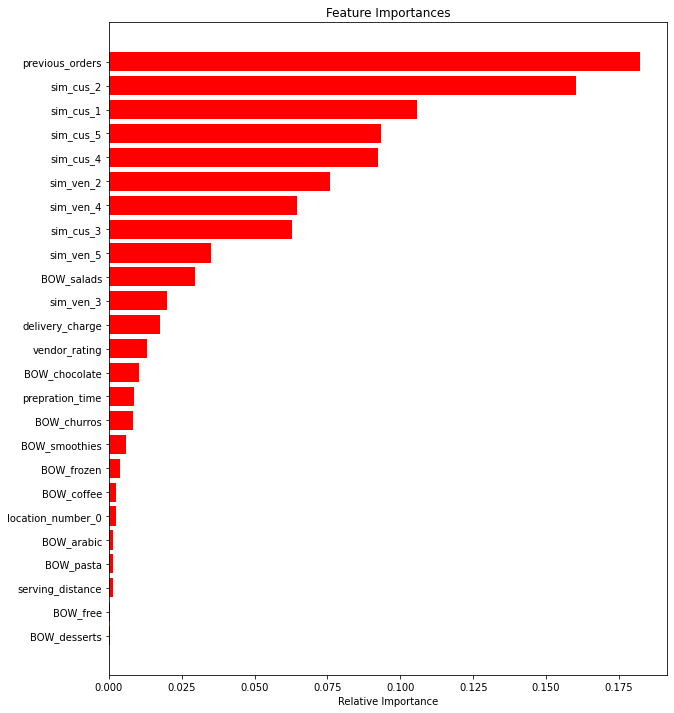

In [17]:
features = train_upsampled.columns
importances = clf_rf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# **Applying catboost classifier**

In [18]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [21]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
  iterations=100,
  learning_rate=0.03
)

In [ ]:
model_cat.fit(train_upsampled, y_tr)
y_pred_cat=model_cat.predict(test_df)
acc_score_cat=accuracy_score(y_test, y_pred_cat)
f1_score_cat=f1_score(y_test, y_pred_cat)

In [23]:
print('the accuracy obtained after applying GBDT is ',acc_score_cat)
print('the f1_score obtained after applying GBDT is ',f1_score_cat)

the accuracy obtained after applying GBDT is  0.9821912771726642
the f1_score obtained after applying GBDT is  0.6023230862527406


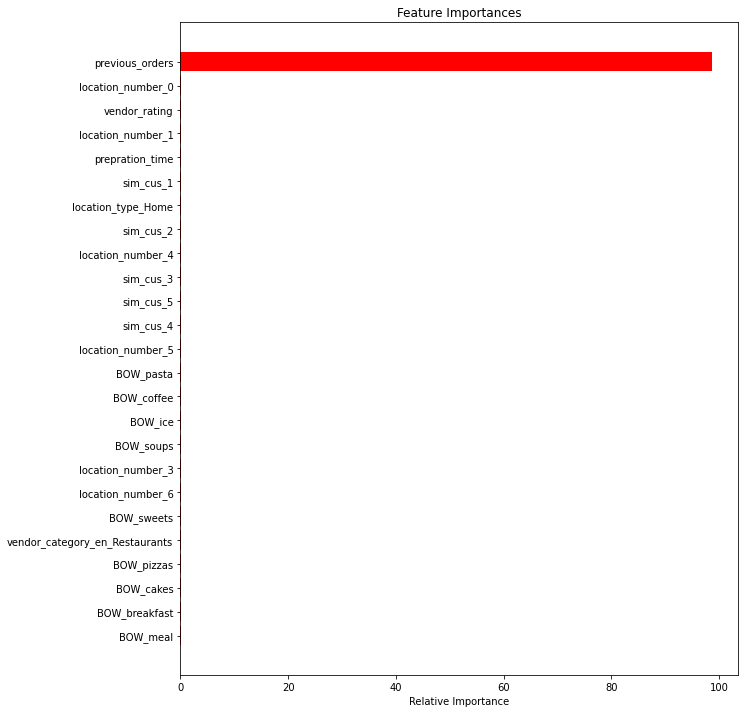

In [24]:
features = train_upsampled.columns
importances = model_cat.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# **Applying gradient boosting decision tree classifier**

In [ ]:
clf_gb = GradientBoostingClassifier(n_estimators=30, learning_rate=1.0,
                                 max_depth=3, random_state=42).fit(train_df,y_train)


In [26]:
y_pred_gb=clf_gb.predict(test_df)
acc_score_gb=accuracy_score(y_test, y_pred_gb)
f1_score_gb=f1_score(y_test, y_pred_gb)


In [27]:
print('the accuracy obtained after applying GBDT is ',acc_score_gb)
print('the f1_score obtained after applying GBDT is ',f1_score_gb)

the accuracy obtained after applying GBDT is  0.9894056377925122
the f1_score obtained after applying GBDT is  0.48452508004268946


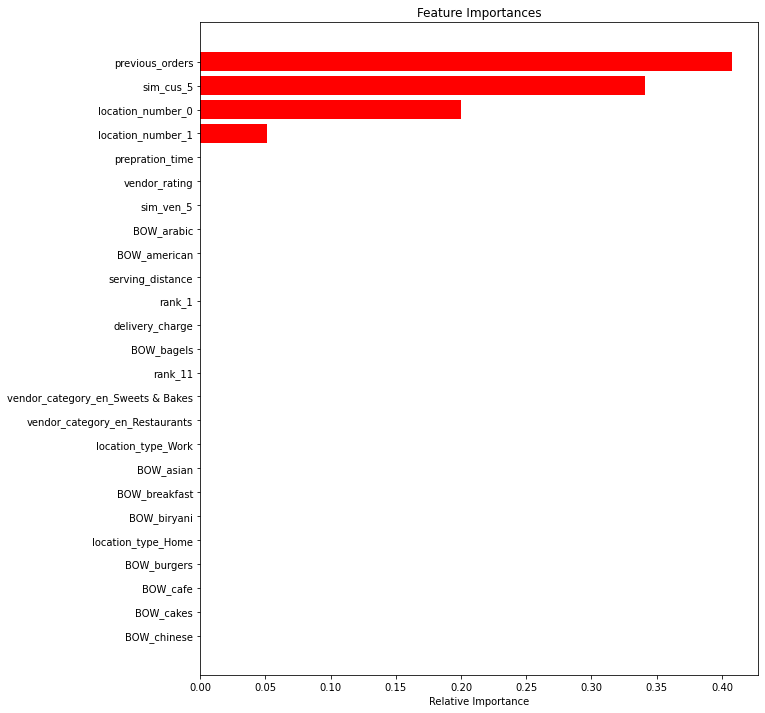

In [28]:
features = train_df.columns
importances = clf_gb.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# **XGBOOST**

In [29]:
train_upsampled1_full = pd.concat([train_upsampled, y_tr], axis=1)
train_upsampled1=train_upsampled1_full.sample(n=250000,random_state=42)

y_tr=pd.DataFrame()
y_tr['target']=train_upsampled1['target']
print(y_tr.shape)

train_upsampled_X=train_upsampled1.drop(['target'], axis = 1)
train_upsampled_X_dense = train_upsampled_X.sparse.to_dense()
print(train_upsampled_X_dense.shape)

(250000, 1)
(250000, 129)


In [30]:
test_full = pd.concat([test_df, y_test], axis=1)
test_df_sample=test_full.sample(n=250000,random_state=42)

y_te=pd.DataFrame()
y_te['target']=test_df_sample['target']
print(y_te.shape)

test_X=test_df_sample.drop(['target'], axis = 1)
test_X_dense = test_X.sparse.to_dense()
print(test_X_dense.shape)

(250000, 1)
(250000, 129)


In [ ]:
train_x = train_upsampled_X_dense.values
test_x = test_X_dense.values

import xgboost as xgb

# initialize Our first XGBoost model...
clf_xgb = xgb.XGBClassifier(silent=False, n_jobs=25, random_state=42, n_estimators=10)
clf_xgb.fit(train_x, y_tr)

y_pred_xgb=clf_xgb.predict(test_x)
acc_score_xgb=accuracy_score(y_te, y_pred_xgb)
f1_score_xgb=f1_score(y_te, y_pred_xgb)


In [32]:
print('the accuracy obtained after applying GBDT is ',acc_score_xgb)
print('the f1_score obtained after applying GBDT is ',f1_score_xgb)


the accuracy obtained after applying GBDT is  0.982052
the f1_score obtained after applying GBDT is  0.6077454322930326


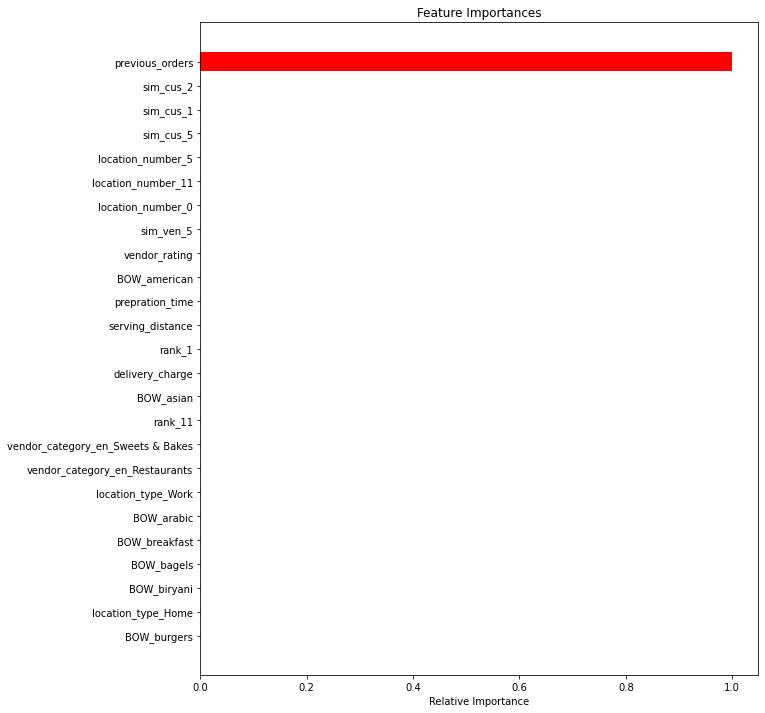

In [33]:
features = train_upsampled.columns
importances = clf_xgb.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# **Transforming data for Surprise models**

**Adding more features to the data:**

**1. Running SurPRISE (Simple Python RecommendatIon System Engine) models with 'number_of_orders' as the target variable.**

**2. The output of each model is made as a new feature in addition to the previous features**

Train data with previous orders

In [3]:
new_orders_full_df = pd.read_csv('/content/drive/MyDrive/Restaurant_2/tr_cus_ven_count.csv',index_col=[0])
new_orders_full_df.reset_index(inplace = True,drop=True)
new_orders_full_df.head(3)

,customer_id,vendor_id,count_order
0,CYNHRLE,67,0.0
1,VX882YK,199,0.0
2,R7SH26P,90,0.0


In [4]:
new_orders_full_test_df = pd.read_csv('/content/drive/MyDrive/Restaurant_2/te_cus_ven_count.csv',index_col=[0])
new_orders_full_test_df.reset_index(inplace = True,drop=True)
new_orders_full_test_df.head(3)

,customer_id,vendor_id,count_order
0,ADSJ32G,159,0.0
1,QXRNSE0,90,0.0
2,EZ5Y3LL,55,0.0


In [5]:
y_train = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/y_train.csv',index_col=[0])
y_test = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/y_test.csv',index_col=[0])
y_train.reset_index(inplace = True,drop=True)
y_test.reset_index(inplace = True,drop=True)

**We will take sample of train data to run regression models along with surprise library model outputs**

In [6]:
train_features = scipy.sparse.load_npz('/content/drive/MyDrive/Restaurant_recommendation_system/new1_train_dataframe_sparse_1.npz')
train_features_df=pd.DataFrame.sparse.from_spmatrix(train_features)
train_feature_list=['gender_Female', 'gender_Male', 'location_number_0', 'location_number_1', 'location_number_3', 'location_number_2', 'location_number_4', 'location_number_5', 'location_number_7', 'location_number_18', 'location_number_8', 'location_number_6', 'location_number_14', 'location_number_9', 'location_number_19', 'location_number_10', 'location_number_28', 'location_number_12', 'location_number_13', 'location_number_17', 'location_number_16', 'location_number_11', 'location_number_21', 'location_number_15', 'location_number_27', 'location_number_24', 'location_number_20', 'location_number_22', 'location_number_25', 'location_number_26', 'location_number_29', 'location_number_23', 'location_type_Home', 'location_type_Other', 'location_type_Work', 'vendor_category_en_Restaurants', 'vendor_category_en_Sweets & Bakes', 'rank_11', 'rank_1', 'delivery_charge', 'vendor_rating', 'serving_distance', 'prepration_time', 'previous_orders', 'BOW_american', 'BOW_arabic', 'BOW_asian', 'BOW_bagels', 'BOW_biryani', 'BOW_breakfast', 'BOW_burgers', 'BOW_cafe', 'BOW_cakes', 'BOW_chinese', 'BOW_chocolate', 'BOW_churros', 'BOW_coffee', 'BOW_combos', 'BOW_creams', 'BOW_crepes', 'BOW_delivery', 'BOW_desserts', 'BOW_dimsum', 'BOW_dogs', 'BOW_donuts', 'BOW_family', 'BOW_fatayers', 'BOW_food', 'BOW_free', 'BOW_fresh', 'BOW_fries', 'BOW_frozen', 'BOW_grills', 'BOW_healthy', 'BOW_hot', 'BOW_ice', 'BOW_indian', 'BOW_italian', 'BOW_japanese', 'BOW_juices', 'BOW_karak', 'BOW_kebabs', 'BOW_kids', 'BOW_kushari', 'BOW_latte', 'BOW_lebanese', 'BOW_manakeesh', 'BOW_mandazi', 'BOW_meal', 'BOW_mexican', 'BOW_milkshakes', 'BOW_mishkak', 'BOW_mojitos', 'BOW_omani', 'BOW_organic', 'BOW_pancakes', 'BOW_pasta', 'BOW_pastas', 'BOW_pastry', 'BOW_pizza', 'BOW_pizzas', 'BOW_rice', 'BOW_rolls', 'BOW_salads', 'BOW_sandwiches', 'BOW_seafood', 'BOW_shawarma', 'BOW_shuwa', 'BOW_smoothies', 'BOW_soups', 'BOW_spanish', 'BOW_steaks', 'BOW_sushi', 'BOW_sweets', 'BOW_thai', 'BOW_thali', 'BOW_vegetarian', 'BOW_waffles', 'BOW_yoghurt', 'sim_cus_1', 'sim_cus_2', 'sim_cus_3', 'sim_cus_4', 'sim_cus_5', 'sim_ven_1', 'sim_ven_2', 'sim_ven_3', 'sim_ven_4', 'sim_ven_5']
train_features_df.columns = train_feature_list

new_orders_full_df=new_orders_full_df[['customer_id','vendor_id']]
train_full_=pd.concat([new_orders_full_df,train_features_df,y_train],axis=1)
train_full_.head(3)


,customer_id,vendor_id,gender_Female,gender_Male,location_number_0,location_number_1,location_number_3,location_number_2,location_number_4,location_number_5,...,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,target
0,CYNHRLE,67,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,VX882YK,199,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,R7SH26P,90,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
test_features = scipy.sparse.load_npz('/content/drive/MyDrive/Restaurant_recommendation_system/new1_test_dataframe_sparse_1.npz')
test_features_df=pd.DataFrame.sparse.from_spmatrix(test_features)
test_feature_list=['gender_Male', 'gender_Female', 'location_number_0', 'location_number_1', 'location_number_3', 'location_number_2', 'location_number_5', 'location_number_4', 'location_number_7', 'location_number_6', 'location_number_13', 'location_number_11', 'location_number_10', 'location_number_9', 'location_number_29', 'location_number_14', 'location_number_8', 'location_number_24', 'location_number_15', 'location_number_12', 'location_number_22', 'location_number_16', 'location_number_25', 'location_number_26', 'location_number_28', 'location_number_20', 'location_number_17', 'location_number_18', 'location_number_27', 'location_number_23', 'location_number_19', 'location_number_21', 'location_type_Home', 'location_type_Work', 'location_type_Other', 'vendor_category_en_Restaurants', 'vendor_category_en_Sweets & Bakes', 'rank_11', 'rank_1', 'delivery_charge', 'vendor_rating', 'serving_distance', 'prepration_time', 'previous_orders', 'BOW_american', 'BOW_arabic', 'BOW_asian', 'BOW_bagels', 'BOW_biryani', 'BOW_breakfast', 'BOW_burgers', 'BOW_cafe', 'BOW_cakes', 'BOW_chinese', 'BOW_chocolate', 'BOW_churros', 'BOW_coffee', 'BOW_combos', 'BOW_creams', 'BOW_crepes', 'BOW_delivery', 'BOW_desserts', 'BOW_dimsum', 'BOW_dogs', 'BOW_donuts', 'BOW_family', 'BOW_fatayers', 'BOW_food', 'BOW_free', 'BOW_fresh', 'BOW_fries', 'BOW_frozen', 'BOW_grills', 'BOW_healthy', 'BOW_hot', 'BOW_ice', 'BOW_indian', 'BOW_italian', 'BOW_japanese', 'BOW_juices', 'BOW_karak', 'BOW_kebabs', 'BOW_kids', 'BOW_kushari', 'BOW_latte', 'BOW_lebanese', 'BOW_manakeesh', 'BOW_mandazi', 'BOW_meal', 'BOW_mexican', 'BOW_milkshakes', 'BOW_mishkak', 'BOW_mojitos', 'BOW_omani', 'BOW_organic', 'BOW_pancakes', 'BOW_pasta', 'BOW_pastas', 'BOW_pastry', 'BOW_pizza', 'BOW_pizzas', 'BOW_rice', 'BOW_rolls', 'BOW_salads', 'BOW_sandwiches', 'BOW_seafood', 'BOW_shawarma', 'BOW_shuwa', 'BOW_smoothies', 'BOW_soups', 'BOW_spanish', 'BOW_steaks', 'BOW_sushi', 'BOW_sweets', 'BOW_thai', 'BOW_thali', 'BOW_vegetarian', 'BOW_waffles', 'BOW_yoghurt', 'sim_cus_1', 'sim_cus_2', 'sim_cus_3', 'sim_cus_4', 'sim_cus_5', 'sim_ven_1', 'sim_ven_2', 'sim_ven_3', 'sim_ven_4', 'sim_ven_5']
test_features_df.columns = test_feature_list

new_orders_full_test_df=new_orders_full_test_df[['customer_id','vendor_id']]
test_full_=pd.concat([new_orders_full_test_df,test_features_df,y_test],axis=1)
test_full_.head(3)

,customer_id,vendor_id,gender_Male,gender_Female,location_number_0,location_number_1,location_number_3,location_number_2,location_number_5,location_number_4,...,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,target
0,ADSJ32G,159,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,QXRNSE0,90,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,EZ5Y3LL,55,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


**Sampling train data**

In [8]:
train_full_ = train_full_.groupby('target').apply(lambda x: x.sample(n=50000)).reset_index(drop = True)
train_full_.head(3)

,customer_id,vendor_id,gender_Female,gender_Male,location_number_0,location_number_1,location_number_3,location_number_2,location_number_4,location_number_5,...,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,target
0,2VBCGZM,188,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,GSHNFD5,207,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,SKIEK8R,676,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
train_full_['target'].value_counts()

0    50000
1    50000
Name: target, dtype: int64

In [11]:
train_full_.to_csv('/content/drive/MyDrive/Restaurant_recommendation_system/train_full_1.csv')
test_full_.to_csv('/content/drive/MyDrive/Restaurant_recommendation_system/test_full_1.csv')

In [ ]:
train_full_ = pd.read_csv('/content/drive/MyDrive/train_full_.csv',index_col=[0])
test_full_ = pd.read_csv('/content/drive/MyDrive/test_full_.csv',index_col=[0])

In [12]:
pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 12.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633727 sha256=cbe635fc17e7b8845bf94d79ffe1ea4be0c3c4b8ffa4eaca5686ce8cf76ef59e
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [15]:
from surprise import Reader, Dataset

reader = Reader(rating_scale=(0,max(train_full_['previous_orders'])))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(train_full_[['customer_id', 'vendor_id', 'previous_orders']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

# Transforming test data

testset = list(zip(test_full_.customer_id.values, test_full_.vendor_id.values, test_full_.previous_orders.values))
testset[:3]

[('ADSJ32G', 159, 0), ('QXRNSE0', 90, 0), ('EZ5Y3LL', 55, 0)]

# **Applying surprise models**

In [16]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

In [17]:
# code snippets used from Netflix_movie_rating prediction case study of Applied AI and modified according to this challenge

# to get rmse given actual and predicted number of orders..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    return rmse

def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse of train data...
    rmse_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'predictions' : y_train_pred}
    if verbose:
        print('\nTRAIN DATA')
        print('-'*30)
        print('RMSE : ', rmse_train)
    #######################################
    # get the test data predictions and compute rmse 
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        
    # return these train and test results...
    return train_results, test_results
    

In [18]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...
import random
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_number_of_orders(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_number_of_orders(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))

    return rmse

##################################################################################
# It will return predicted number of orders and rmse of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 2 key-value pairs, which specify ''rmse''  and ''predicted number of orders''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted number of orders from the train predictions..
    train_actual_ratings, train_pred_ratings = get_number_of_orders(train_preds)
    # get ''rmse'' from the train predictions.
    train_rmse = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}".format(train_rmse))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_number_of_orders(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}".format(test_rmse))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

# **XGBoost with initial 13 features**

In [21]:
import xgboost as xgb

In [19]:
y_train_sample = train_full_['target']
train_full_ = train_full_.drop(['target'], axis=1)

y_test_sample = test_full_['target']
test_full_ = test_full_.drop(['target'], axis=1)

In [20]:
# prepare Train data customer_id	id	previous_orders
x_train_run = train_full_.drop(['customer_id','vendor_id','previous_orders'], axis=1)
y_train_run = train_full_['previous_orders']

# Prepare Test data
x_test_run = test_full_.drop(['customer_id','vendor_id','previous_orders'], axis=1)
y_test_run = test_full_['previous_orders']

Training the model..
[10:40:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:28.115819

Done 

Evaluating the model with TRAIN data...

TRAIN DATA
------------------------------
RMSE :  0.012060402182662399
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.0030433181181641128


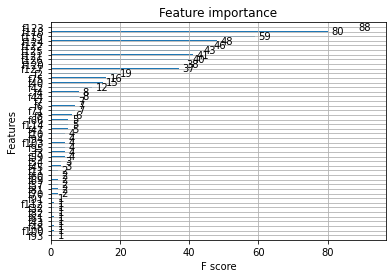

In [22]:
# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train_run.values, y_train_run, x_test_run.values, y_test_run)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

# **Surprise Baseline Predictor**

In [23]:
from surprise import BaselineOnly 

In [24]:
# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.791766 

Evaluating the model with train data..
time taken : 0:00:00.940676
---------------
Train Data
---------------
RMSE : 0.016689332243442417
adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:14.540091
---------------
Test Data
---------------
RMSE : 0.008664358231853414
storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:16.278637


# **XGBoost with initial 13 features + Surprise Baseline predictor**

**Updating Train Data**

In [25]:
# add our baseline_predicted value as our feature..
x_train_run['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
x_train_run.head(2) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,gender_Female,gender_Male,location_number_0,location_number_1,location_number_3,location_number_2,location_number_4,location_number_5,location_number_7,location_number_18,...,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,bslpr
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005193
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005396


**Updating Test Data**

In [26]:
# add that baseline predicted ratings with Surprise to the test data as well
x_test_run['bslpr']  = models_evaluation_test['bsl_algo']['predictions']
x_test_run.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,gender_Male,gender_Female,location_number_0,location_number_1,location_number_3,location_number_2,location_number_5,location_number_4,location_number_7,location_number_6,...,sim_cus_2,sim_cus_3,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,bslpr
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013828
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008883


Training the model..
[10:44:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:32.320608

Done 

Evaluating the model with TRAIN data...

TRAIN DATA
------------------------------
RMSE :  0.012053997085993183
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.00304682165639624


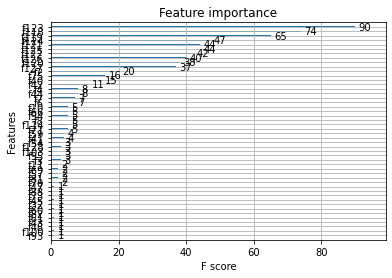

In [27]:
# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train_run.values, y_train_run, x_test_run.values, y_test_run)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()

# **Matrix Factorization Techniques**

**SVD Matrix Factorization User Movie intractions**

In [31]:
from surprise import SVD

In [32]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:06.570032 

Evaluating the model with train data..
time taken : 0:00:00.934995
---------------
Train Data
---------------
RMSE : 0.01590977548211681
adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:23.622260
---------------
Test Data
---------------
RMSE : 0.0128780945031891
storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:31.133981


**SVD Matrix Factorization with implicit feedback from user ( user rated movies )**

In [33]:
from surprise import SVDpp
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:00:26.847639 

Evaluating the model with train data..
time taken : 0:00:03.193857
---------------
Train Data
---------------
RMSE : 0.015169026995537786
adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:55.146065
---------------
Test Data
---------------
RMSE : 0.010893855257932326
storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:01:25.194297


In [34]:
model_op_pd=pd.DataFrame()
model_op_pd['bsl_algo'] = models_evaluation_train['bsl_algo']['predictions']
model_op_pd['first_algo'] = models_evaluation_train['first_algo']['predictions']
model_op_pd['svd'] = models_evaluation_train['svd']['predictions']
model_op_pd['svdpp'] = models_evaluation_train['svdpp']['predictions']
model_op_pd['xgb_bsl'] = models_evaluation_train['xgb_bsl']['predictions']

In [35]:
model_op_te_pd=pd.DataFrame()
model_op_te_pd['bsl_algo'] = models_evaluation_test['bsl_algo']['predictions']
model_op_te_pd['first_algo'] = models_evaluation_test['first_algo']['predictions']
model_op_te_pd['svd'] = models_evaluation_test['svd']['predictions']
model_op_te_pd['svdpp'] = models_evaluation_test['svdpp']['predictions']
model_op_te_pd['xgb_bsl'] = models_evaluation_test['xgb_bsl']['predictions']

In [38]:
model_op_pd.to_csv('/content/drive/MyDrive/Restaurant_recommendation_system/model_op_pd_1.csv')
model_op_te_pd.to_csv('/content/drive/MyDrive/Restaurant_recommendation_system/model_op_te_pd_1.csv')

In [39]:
model_op_pd = pd.read_csv('/content/drive/MyDrive/model_op_pd.csv',index_col=[0])
model_op_te_pd = pd.read_csv('/content/drive/MyDrive/model_op_te_pd.csv',index_col=[0])

# **XgBoost with 13 features + Surprise Baseline + MF Techniques**

In [ ]:
y_train_sample = train_full_['target']
train_full_ = train_full_.drop(['target'], axis=1)

y_test_sample = test_full_['target']
test_full_ = test_full_.drop(['target'], axis=1)

In [44]:
train_full_['previous_orders'].head(3)

0    0.0
1    0.0
2    0.0
Name: previous_orders, dtype: Sparse[float64, 0]

**Preparing Train data**

In [45]:
y_train_run = train_full_['previous_orders']
x_train_run = train_full_.drop(['customer_id','vendor_id','previous_orders'],axis=1)
x_train_run[['bsl_algo','svd','svdpp']]=model_op_pd[['bsl_algo','svd','svdpp']]
x_train_run.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


,gender_Female,gender_Male,location_number_0,location_number_1,location_number_3,location_number_2,location_number_4,location_number_5,location_number_7,location_number_18,...,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,bsl_algo,svd,svdpp
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005193,0.000000,0.007484
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005396,0.016361,0.006919
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020512,0.021812,0.020227


**Preparing Test data**

In [47]:
y_test_run = test_full_['previous_orders']
x_test_run = test_full_.drop(['customer_id','vendor_id','previous_orders'],axis=1)
x_test_run[['bsl_algo','svd','svdpp']]=model_op_te_pd[['bsl_algo','svd','svdpp']]
x_test_run.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


,gender_Male,gender_Female,location_number_0,location_number_1,location_number_3,location_number_2,location_number_5,location_number_4,location_number_7,location_number_6,...,sim_cus_4,sim_cus_5,sim_ven_1,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,bsl_algo,svd,svdpp
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013828,0.021494,0.000531
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008883,0.006332,0.009152
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005477,0.013811,0.003020


Training the model..
[11:14:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:29.547754

Done 

Evaluating the model with TRAIN data...

TRAIN DATA
------------------------------
RMSE :  0.012064161794004574
Evaluating Test data

TEST DATA
------------------------------
RMSE :  0.0030556424735202815


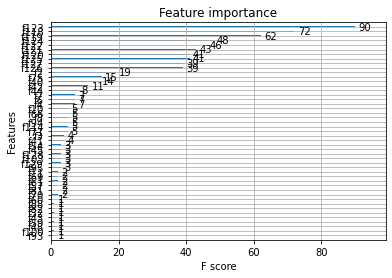

In [48]:
xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train_run.values, y_train_run, x_test_run.values, y_test_run)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

In [49]:
model_op_pd['xgb_final']=models_evaluation_train['xgb_final']['predictions']
model_op_te_pd['xgb_final']=models_evaluation_test['xgb_final']['predictions']

In [52]:
model_op_pd.to_csv('/content/drive/MyDrive/Restaurant_recommendation_system/model_op_pd_1.csv')
model_op_te_pd.to_csv('/content/drive/MyDrive/Restaurant_recommendation_system/model_op_te_pd_1.csv')

In [ ]:
model_op_pd.to_csv('/content/drive/MyDrive/model_op_pd_1.csv')
model_op_te_pd.to_csv('/content/drive/MyDrive/model_op_te_pd_1.csv')

# **Preparing train and test data**

In [53]:
model_outputs_tr = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/model_op_pd_1.csv',index_col=[0])
X_final_tr = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/train_full_1.csv',index_col=[0])
y_final_tr = X_final_tr['target']
X_final_tr = X_final_tr.drop(['customer_id','vendor_id','target'],axis=1)

X_final_tr = pd.concat([X_final_tr,model_outputs_tr],axis=1)
X_final_tr.head(3)

,gender_Female,gender_Male,location_number_0,location_number_1,location_number_3,location_number_2,location_number_4,location_number_5,location_number_7,location_number_18,...,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,bsl_algo,first_algo,svd,svdpp,xgb_bsl,xgb_final
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.005193,0.000582,0.000000,0.007484,0.000531,0.000684
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.005396,0.001453,0.016361,0.006919,0.001366,0.001378
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.020512,0.001007,0.021812,0.020227,0.001023,0.001115


In [54]:
model_outputs_te = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/model_op_te_pd_1.csv',index_col=[0])
X_final_te = pd.read_csv('/content/drive/MyDrive/Restaurant_recommendation_system/test_full_1.csv',index_col=[0])
y_final_te = X_final_te['target']
X_final_te = X_final_te.drop(['customer_id','vendor_id','target'],axis=1)

X_final_te = pd.concat([X_final_te,model_outputs_te],axis=1)
X_final_te.head(3)

,gender_Male,gender_Female,location_number_0,location_number_1,location_number_3,location_number_2,location_number_5,location_number_4,location_number_7,location_number_6,...,sim_ven_2,sim_ven_3,sim_ven_4,sim_ven_5,bsl_algo,first_algo,svd,svdpp,xgb_bsl,xgb_final
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.013828,0.000760,0.021494,0.000531,0.000613,0.000742
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.008883,0.000921,0.006332,0.009152,0.001032,0.001015
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.005477,0.000948,0.013811,0.003020,0.001060,0.000920


# **Applying logistic regression on added features**

In [ ]:
clf = LogisticRegression(random_state=42,max_iter=100).fit(X_final_tr, y_final_tr)

y_pred=clf.predict(X_final_te)
acc_score=accuracy_score(y_final_te, y_pred)
f1_score_=f1_score(y_final_te, y_pred)

In [56]:
print('the accuracy obtained after applying logistic regression is ',acc_score)
print('the f1 score obtained after applying logistic regression is ',f1_score_)

the accuracy obtained after applying logistic regression is  0.9848364730999503
the f1 score obtained after applying logistic regression is  0.6019494673923474


# **Applying Decision Tree on added features**

In [57]:
max_depth_list=[5,10]
min_samples_split=[5, 10, 100, 500, 1000]

for i in max_depth_list:

  for j in min_samples_split:

    clf_dt=DecisionTreeClassifier(max_depth=i,min_samples_split=j)
    clf_dt.fit(X_final_tr, y_final_tr)

    y_pred_dt=clf_dt.predict(X_final_te)
    acc_score_dt=accuracy_score(y_final_te, y_pred_dt)
    f1_score_dt=f1_score(y_final_te, y_pred_dt)

    print('Decision tree with max_depth {} and min_samples_split {}, accuracy obtained is {} and f1_score obtained is {}'.format(i,j,acc_score_dt,f1_score_dt))


Decision tree with max_depth 5 and min_samples_split 5, accuracy obtained is 0.9821996331716447 and f1_score obtained is 0.6021663515185471
Decision tree with max_depth 5 and min_samples_split 10, accuracy obtained is 0.9822017221713899 and f1_score obtained is 0.6022501809014729
Decision tree with max_depth 5 and min_samples_split 100, accuracy obtained is 0.9821970219219633 and f1_score obtained is 0.6021869274486236
Decision tree with max_depth 5 and min_samples_split 500, accuracy obtained is 0.9821949329222182 and f1_score obtained is 0.6021123883993698
Decision tree with max_depth 5 and min_samples_split 1000, accuracy obtained is 0.9821912771726642 and f1_score obtained is 0.602146774005367
Decision tree with max_depth 10 and min_samples_split 5, accuracy obtained is 0.9822847599112593 and f1_score obtained is 0.6028683486507054
Decision tree with max_depth 10 and min_samples_split 10, accuracy obtained is 0.9822905046605585 and f1_score obtained is 0.6030296644892417
Decision t

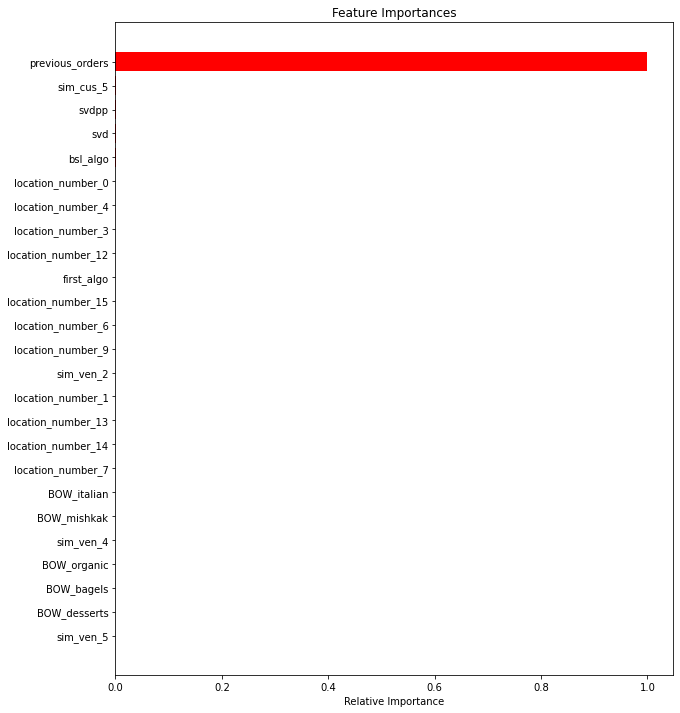

In [58]:
features = X_final_tr.columns
importances = clf_dt.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# **Applying random forest on added features**

In [59]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42).fit(X_final_tr, y_final_tr)

y_pred_rf=clf_rf.predict(X_final_te)
acc_score_rf=accuracy_score(y_final_te, y_pred_rf)
f1_score_rf=f1_score(y_final_te, y_pred_rf)


In [60]:
print('the accuracy obtained after applying random forest is ',acc_score_rf)
print('the f1_score_rf obtained after applying random forest is ',f1_score_rf)

the accuracy obtained after applying random forest is  0.9822048556710076
the f1_score_rf obtained after applying random forest is  0.602422290674881


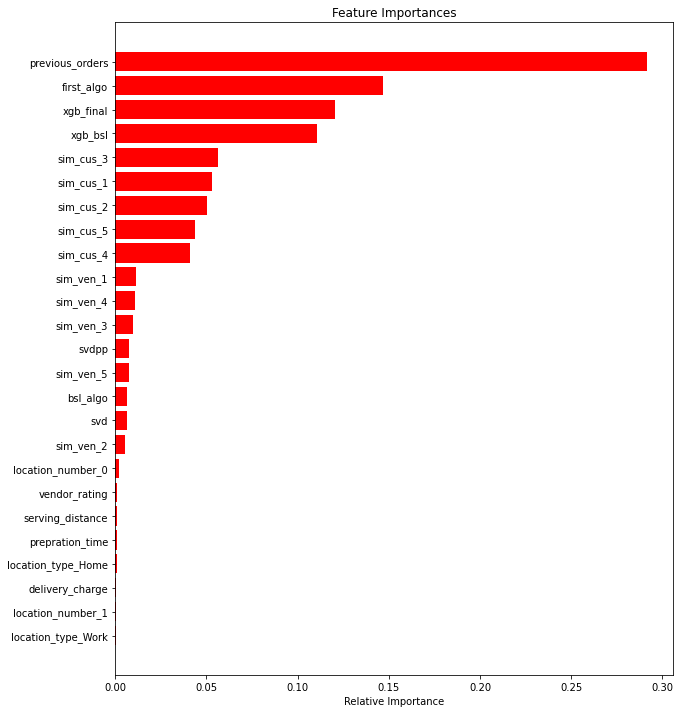

In [61]:
features = X_final_tr.columns
importances = clf_rf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# **Recommendation system**

## **Recommend similar vendors**

In [ ]:
# counting orders from train dataset

orders=pd.read_csv('/content/Restaurant/orders.csv')

#selecting customer_id and vendor_id from the orders data
new_orders_df=orders[['customer_id','vendor_id']]

# counting the repeated orders
new_orders_df=new_orders_df.groupby(new_orders_df.columns.tolist(),as_index=False).size()
count_orders=new_orders_df['size'].tolist()
new_orders_df['count_orders']=count_orders

# mapping customer_id to an integer value
customer_id_list=new_orders_df['customer_id']
x = list(set(customer_id_list))
customer_id_list_dic = dict(zip(x, list(range(1,len(x)+1))))
new_cust_id=[customer_id_list_dic[v] for v in customer_id_list]
new_orders_df['new_cust_id']=new_cust_id

new_orders_df_1=pd.concat([new_orders_df['new_cust_id'],new_orders_df['vendor_id'],new_orders_df['count_orders']],axis=1)
new_orders_df_1.head(5)

In [4]:
# creating sparse matrix

train_sparse_matrix = sparse.csr_matrix((new_orders_df_1.count_orders.values, (new_orders_df_1.new_cust_id.values,
                                            new_orders_df_1.vendor_id.values)),)

print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)

Done. It's shape is : (user, movie) :  (27446, 908)


In [14]:
# computing similarity among vendors

v_v_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)

print("It's a ",v_v_sim_sparse.shape," dimensional matrix")

It's a  (908, 908)  dimensional matrix


In [15]:
# computing similarity vendors and saving in a dictionary

vendor_ids = np.unique(v_v_sim_sparse.nonzero()[1])

similar_vendors = dict()
for vendor in vendor_ids:
    # get the top similar vendors and store them in the dictionary
    sim_vendors = v_v_sim_sparse[vendor].toarray().ravel().argsort()[::-1][1:]
    similar_vendors[vendor] = sim_vendors[:5]


In [16]:
# unique vendors

vendor_ids

array([  4,  13,  20,  23,  28,  33,  43,  44,  55,  66,  67,  75,  76,
        78,  79,  81,  82,  83,  84,  85,  86,  90,  92, 104, 105, 106,
       110, 113, 115, 134, 145, 148, 149, 154, 157, 159, 160, 161, 176,
       180, 188, 189, 191, 192, 193, 195, 196, 197, 199, 201, 203, 207,
       216, 221, 225, 231, 237, 243, 250, 259, 265, 271, 274, 288, 289,
       294, 295, 298, 299, 300, 303, 304, 310, 356, 386, 391, 398, 401,
       419, 459, 537, 547, 573, 575, 577, 578, 582, 583, 676, 679, 681,
       841, 843, 845, 846, 849, 855, 856, 858, 907], dtype=int32)

In [18]:
# finding similar vendors to vendor=4

similar_vendors[4]

array([ 13, 159,  82,  81, 104])

In [19]:
# finding similar vendors to vendor=907

similar_vendors[907]

array([ 86, 237,  44,  85, 193])

## **Recommend similar customers**

In [5]:
# computing similarity among customers

c_c_sim_sparse = cosine_similarity(X=train_sparse_matrix, dense_output=False)

print("It's a ",c_c_sim_sparse.shape," dimensional matrix")

It's a  (27446, 27446)  dimensional matrix


In [6]:
# computing similarity customers and saving in a dictionary

customer_ids = np.unique(c_c_sim_sparse.nonzero()[1])

similar_customers = dict()
for customer in customer_ids:
    # get the top similar customers and store them in the dictionary
    sim_customers = c_c_sim_sparse[customer].toarray().ravel().argsort()[::-1][1:]
    similar_customers[customer] = sim_customers[:5]


In [7]:
# unique customer ids

customer_ids

array([    1,     2,     3, ..., 27443, 27444, 27445], dtype=int32)

In [23]:
# customer names

print(customer_id_list_dic)

{'WSPJ7JO': 1, 'HPGXPKU': 2, 'AX8M273': 3, 'XOH9J1I': 4, 'KTE7MHD': 5, 'UTFCT0A': 6, 'FQFQBMP': 7, '4F7FZ1G': 8, 'H9HFTE5': 9, 'MARQK8V': 10, 'LFXK9QH': 11, 'TPCWY2M': 12, '114UZCM': 13, 'AVD95T0': 14, 'V3CQ7R2': 15, '6D1W3L9': 16, 'OSOZS7J': 17, 'YH8KVXU': 18, 'GBKN4J5': 19, 'J1YGCHK': 20, 'QYA7N72': 21, 'T37YKQQ': 22, 'OHC0K74': 23, 'HR7JW55': 24, '7C3BV4G': 25, 'DGIPU6T': 26, 'V1U1FFK': 27, 'SKFV658': 28, 'CXNFM13': 29, 'CSDZMQW': 30, 'ONFHB33': 31, 'DWWSU51': 32, 'A1U8ZU0': 33, 'MD85J6U': 34, 'OQZ8Z6D': 35, '80YWU4H': 36, 'V8OJXYC': 37, 'NE6ZHRW': 38, 'SQ8ZPJP': 39, 'QNXWTU8': 40, 'XR0J5DL': 41, 'O25XXF6': 42, 'FPD6ZU5': 43, 'GX0F6F3': 44, 'CSK98OV': 45, 'NDHNQJD': 46, '06E9VIK': 47, 'GJES9OA': 48, '7AMCAGF': 49, 'IW2LHP8': 50, '49ISCO2': 51, 'H8TMAD7': 52, 'QZWBCC0': 53, 'FINZB1J': 54, 'N3R0PD5': 55, 'ML8P0U3': 56, 'AXT1Z5O': 57, '8XFYZ3P': 58, 'QXRK70O': 59, 'MJG2VYL': 60, '18NSFPK': 61, 'BLLN4EL': 62, 'X5ZI0RO': 63, 'ACLJBSG': 64, 'FUN1PNF': 65, 'GYF3M81': 66, 'PPH8X8A': 67, 'KK

In [13]:
# finding similar customers to 'WSPJ7JO'

similar_cus_arr=similar_customers[customer_id_list_dic['WSPJ7JO']]

similar_cus_arr_name=[]
for i in similar_cus_arr:
  similar_cus_arr_name.append(list(customer_id_list_dic.keys())[list(customer_id_list_dic.values()).index(i)])

similar_cus_arr_name

['BB82808', 'UZ2P3XE', 'JHFN5TG', 'SFRIIHD', '8ZXA7NF']

In [20]:
# finding similar customers to 'HPGXPKU'

similar_cus_arr=similar_customers[customer_id_list_dic['HPGXPKU']]

similar_cus_arr_name=[]
for i in similar_cus_arr:
  similar_cus_arr_name.append(list(customer_id_list_dic.keys())[list(customer_id_list_dic.values()).index(i)])

similar_cus_arr_name

['JS2RVZF', 'IXRUG1T', 'U2M2GNP', 'GFU5KQ0', '6J3ZV37']

# **Summary and Conclusion**


In [62]:
#tabulating results
from prettytable import PrettyTable

results=PrettyTable(['model', 'accuracy','f1_score'])
results.add_row(['Logistic Regression','0.9841867941792111','0.6041495077852296'])
results.add_row(['Decision Tree', '0.982200155421581','0.602423973777223'])
results.add_row(['Random Forest','0.9841204684373028','0.602151100410855'])
results.add_row(['Catboost classifier','0.9821912771726642','0.6023230862527406'])
results.add_row(['GradientBoosting Classifier','0.9894056377925122','0.48452508004268946'])
results.add_row(['XGBoost Classifier','0.982052','0.6077454322930326'])
results.add_row(['Logistic_Regression_with_SurPRISE_model_features','0.9848364730999503','0.6019494673923474'])
results.add_row(['Decision_tree_with_SurPRISE_model_features','0.9822184341693511','0.6023544800523217'])
results.add_row(['Random_Forest_with_SurPRISE_model_features','0.9822048556710076','0.602422290674881'])

print(results)

+--------------------------------------------------+--------------------+---------------------+
|                      model                       |      accuracy      |       f1_score      |
+--------------------------------------------------+--------------------+---------------------+
|               Logistic Regression                | 0.9841867941792111 |  0.6041495077852296 |
|                  Decision Tree                   | 0.982200155421581  |  0.602423973777223  |
|                  Random Forest                   | 0.9841204684373028 |  0.602151100410855  |
|               Catboost classifier                | 0.9821912771726642 |  0.6023230862527406 |
|           GradientBoosting Classifier            | 0.9894056377925122 | 0.48452508004268946 |
|                XGBoost Classifier                |      0.982052      |  0.6077454322930326 |
| Logistic_Regression_with_SurPRISE_model_features | 0.9848364730999503 |  0.6019494673923474 |
|    Decision_tree_with_SurPRISE_model_f

**Output:**
1. The accuracy of all the models are found to be around 0.98.
2. The f1_score of all the models are found tobe around 0.60 except for GradientBoosting Classifier.

**The important features obtained for the models are**

1. Decision Tree: 'previous_orders'
2. Random Forest: 
'sim_cus_2' , 'sim_cus_1' , 'previous_orders' , 'sim_cus_5' ,'sim_cus_3' , 'sim_cus_2'
3. Catboost classifier: 'previous_orders', 'location_number_0' , 'vendor_rating'
4. GradientBoosting Classifier: 'previous_orders','location_number_0', 'sim_cus_4', 'location_number_1'
5. XGBoost Classifier: 'previous_orders'
6. Decision_tree_with_SurPRISE_model_features :   'previous_orders'
7. Random_Forest_with_SurPRISE_model_features :   'previous_orders','first_algo','xgb_final','xgb_bsl','sim_cus_3'

## **Summary**

1. The dataset is imported from kaggle website(**Restaurant recommendation challenge dataset**).
2. The challenge is to predict the possibility of ordering by a customer from a vendor so that vendor could be recommended to customer.
3. The data provided are previous orders made, location details of both customers and vendors, restaurant details, vendor_tags etc
4. Data featurization is made on above features.
5. Based on the available data, similarity among customers and vendors is computed and data from **5 similar customers** and **5 similar vendors** are made as features.
6. The similarities calculated among customers and vendors could be used to build a **recommendation system**.
7. Couple of linear models, decistion tree algorithms are run with above mentioned features.
8. The **SurPRISE library** which is used for recommendation problems is used to build further more features.
9. The outputs of models present in SurPRISE library such as **Baseline model**, **Matrix Factorization** are used as features in addition to above mentioned features.
10. Linear algorithms and decision tree algorithms are run on added features, it is found that the feature dataset performed simliar in all algorithms except Gradient Boosting Classifier.